# Exploring the effects of rainstorm sequences on a river hydrograph
#### This lab was created by graduate students as part of the 2020 CSDMS ESPIn (Earth Surface Processes Institute).

#### Creators

Brooke Hunter - University of Oregon
<br /> 
Celia Trunz - University of Arkansas
<br /> 
Lisa Luna - University of Potsdam
<br /> 
Tianyue Qu - University of Pittsburgh
<br /> 
Yuval Shmilovitz -  The Hebrew University of Jerusalem 

<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>

<hr>

## Notebook Overview

In this notebook we will explore the relationships between rainfall intensity, water stage height, and infiltration through the integration of multiple Landlab components. It expands upon the **Coupled rainfall-runoff model with OverlandFlow** tutorial (see link below). 



### Learning Objectives

Topical learning objectives
1. Concepts of rainfall intensity, storm depth, and hydraulic conductivity
2. Relationships between infiltration depth and hydraulic conductivity
3. Relationships between rainfall intensity distribution and hydrographs

Python Skill Learning Objectives:
1. Communicate between two LandLab components with inputs and outputs
2. Set up a topographic elevation grid from an asci file 
3. Create plots using `matplotlib` 
4. Read inputs from .csv file
5. Use pandas DataFrames
6. Save figure to file

### LandLab Components used
`PrecipitationDistribution`
`OverlandFlow`
`SoilInfiltrationGreenAmpt`

## Conceptual Model

<img align="right" src="https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/ConcepModel.png?raw=true" alt="drawing" width="600"/>
    
#### Step 1
Using the `PrecipitationDistribution` component in Landlab we will generate a single storm that is uniform in space, but varies in rainfall flux over the duration of the storm. This will be done on a simple catchment (`hugo_site.asc`). Rainfall flux will contribute to `surface_water_depth` which will be fed into `soil_water_infiltration__depth`.

#### Step 2
With the `SoilInfiltrationGreenAmpt`, we will calculate the `soil_water_infiltration__depth` and the new `surface_water__depth`. 

#### Step 3
This `surface_water__depth` term is also used in `OverlandFlow`! So now we can run the `OverlandFlow` to determine where (and how much) the water goes. 

<hr>


## Load the following packages

In [1]:
## Import components and pkgs
from landlab.components.uniform_precip import PrecipitationDistribution
import numpy as np
import random
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
from landlab import imshow_grid_at_node                                                                                                                               
from landlab.components import OverlandFlow
import matplotlib.colors as mcolors
from landlab.io import read_esri_ascii
from landlab import load_params
import pandas as pd

## Set up a grid using topography from asci file.

In [2]:
## Import Hugo Site Asci File
fname = 'hugo_site.asc'
## Set up grid to have topographic elevation values of Hugo Site
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE #This line creates a closed boundary around catchment
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED
mg.set_watershed_boundary_condition('topographic__elevation')


## Visualization! 

In the first cell you will see closed boundaries in blue where the model will not be run on these nodes. The area where the model will be run is black.

In the second cell below you will plot the elevation of the Hugo catchment

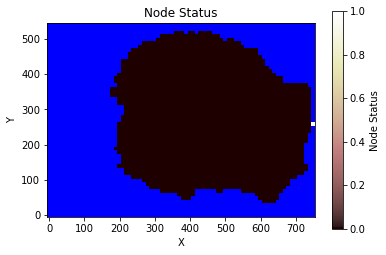

In [3]:
# Show boundries conditions and topography of Hugo Catchment
fig = plt.subplots()
imshow_grid(mg, mg.status_at_node, color_for_closed="blue",
            plot_name = 'Node Status',
            var_name = 'Node Status')


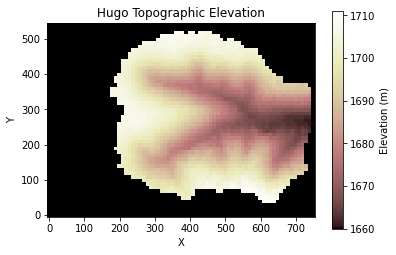

In [4]:
## Show basin topography
fig = plt.subplots()
imshow_grid(mg,                     
            values = z,
            plot_name = 'Hugo Topographic Elevation',
            var_name = 'Elevation (m)')

## Generate rainfall time series with storms
We will use the `PrecipitationDistribution` component in LandLab to generate a month long rainfall time series. This series will have storm events with constant rainfall intensity values throughout the event. With this synthetic dataset of a month's rainfall data, we will calculate storm depth and rainfall intensity. 

This will assume that the rainfall intensity for a given precipitation  event is constant throughout the duration of the event.

The file `storms_params.csv`is provided for the `PrecipitationDistribution` component. This file contains two different rainstorm sequence scenarios with the following parameters. Scenario 1 has shorter storm events, but with higher storm depths (higher intensity) while scenario 2 has longer average precipitation durations, but less intense rainfall. 


| Scenario       | StormDepth   | StormTime     | InterStormTime  | total_time   |
| :------------- | :----------: | :-----------: |  :----------:   | ----------:  |
|  1             | 100          | 8             |  150            | 720          |
|  2             | 50           | 24            |  20             | 720          |

### Parameter Descriptions

#### Storm depth (mm)
Storm depth is defined as the depth of rain that falls during a storm over a specific duration as if distributed evenly across the landscape

#### Storm Time (hours)
Average duration of precipitation event

#### Inter Storm Time (hours)
Average duration between precipitation events 

#### Total Time (hours)
The total amount of time in storm rainfall time series


<small>For more on the `PrecipitationDistribution` module, click here: <a href="https://landlab.readthedocs.io/en/master/reference/components/uniform_precip.html">https://landlab.readthedocs.io/en/master/reference/components/uniform_precip.html</a></small>


<hr>

<br /> 


### Rainfall intensity
Rainfall intensity is defined as the depth of rainfall over a specfic period (often expressed in mm/hr). Here is a schematic of rain gauges and example rainfall intensity calculations. The rain gauge on the left has collected 2mm of rain in two hours while the one on the right collected 5mm of rain in two hours. This results in a rainfall intensity of 1mm/hr and 2.5mm/yr respectively. 


<img align="center" src = "https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/RainfallInten.png?raw=true" alt="drawing" width="600">

<br /> 


## Load Storm parameters CSV with pandas

Below you will load `storms_param.csv`. 


In assignment questions at the end of the notebook you will be asked to change these parameters to make different types of rainfall series. 

To change StormDepth, StormTime, InterStormTime, and totalTime, you can alter this CSV file in two ways.

1. Change scenario 1 and 2's parameters to what you wish
2. Add additional scenarios (3,4, and so on). 

Either one will work with the following script!


In [5]:
## Load rainstorm inputs parameters from user
StormsDF = pd.read_csv('storms_param.csv') # Store rainfall and runoff data for each scenario

In [7]:
#Set time step to one hour and random seed value
delta_t = 1 ## hour
np.random.seed(np.arange(10))

#This counts how many scenarios are listed in cvs
numer_of_scenarios = StormsDF.shape[0]

## Create vectors for saving rainstorms. Each colnum is scenario
## 100 is dummy number. just to make a place
interstorms_dts_vector= np.empty((100,numer_of_scenarios,)) #interstorm intervals
interstorms_dts_vector[:]=np.nan
storms_dts_vector=np.empty((100,numer_of_scenarios,)) #storm intervals
storms_dts_vector[:]=np.nan
intensities_vector = np.empty((100,numer_of_scenarios,)) #rainfall intensities 
intensities_vector[:] = np.nan
times_vector = np.empty((100,numer_of_scenarios,)) # running time 
times_vector[:] = np.nan
rains_vector = np.empty((100,numer_of_scenarios,)) # Rain time (storm+interstorm)
rains_vector[:] = np.nan
depths_vector = np.empty((100,numer_of_scenarios,)) # Depth
depths_vector[:] = np.nan

## Add fields for saving scenario data
StormsDF['n_storms'] = np.nan # number of storms
StormsDF['PeakWaterLevel'] = np.nan # peak water height


In [8]:
## Loop for creating rainstorm series for each of the scenarios
for i in StormsDF.index:
    storm_time = StormsDF.iloc[i]['StormTime']
    print(storm_time)
    storm_intertime = StormsDF.iloc[i]['InterStormTime']
    storm_depth = StormsDF.iloc[i]['StormDepth']
    total_time = StormsDF.iloc[i]['total_time']

    # Initialize generator
    precip = PrecipitationDistribution(mg, mean_storm_duration=storm_time, 
                                       mean_interstorm_duration=storm_intertime, 
                                       mean_storm_depth=storm_depth, total_t=total_time,delta_t=delta_t)
    n = random.randint(1,101) ## random seed number 
    precip.seed_generator(seedval=n)

    ## Iterating on all of the storms and save rainfall data
    # Arrays for saving the outputs.
    storm_dts = []
    interstorm_dts = []
    intensities = []
    depths  = [] 
    total_time=0
    time_vec =[0]
    rain_vec = [0]
    for (storm_dt, interstorm_dt) in precip.yield_storms():   #Each iteration has a storm duration and interstorm duration
        ## Save rainfall data                             #This loop will go over all the storms. precip.yield_storms():    
        storm_dts.append(np.array(storm_dt)) ## hours
        interstorm_dts.append(interstorm_dt) ## hours
        intensities.append(mg.at_grid['rainfall__flux']) ## mm/h
        depths.append(mg.at_grid['rainfall__flux']*storm_dt)
        
        ## Creating rainfall time-series
        total_time += 1
        time_vec.append(total_time)
        rain_vec.append(intensities[-1])
        total_time += storm_dt
        time_vec.append(total_time)
        rain_vec.append(intensities[-1])
        total_time += 1
        time_vec.append(total_time)
        rain_vec.append(0)
        total_time += interstorm_dt
        time_vec.append(total_time)
        rain_vec.append(0)

    time_vec = np.asanyarray(time_vec)*60 ##in minutes   #Full time series will all storms
    rain_vec = np.asanyarray(rain_vec)                   #Rain intensities for full series (mm/hr)
    mg.delete_field('grid','rainfall__flux') # Clear field for the next run
    
    ## Saving rainstorm data
    interstorms_dts_vector[0:len(interstorm_dts),i]=interstorm_dts
    storms_dts_vector[0:len(storm_dts),i]=storm_dts
    intensities_vector[0:len(intensities),i]=intensities
    times_vector[0:len(time_vec),i]=time_vec
    rains_vector[0:len(rain_vec),i]=rain_vec
    depths_vector[0:len(depths),i] = depths
    StormsDF.loc[i,'n_storms'] = np.count_nonzero(~np.isnan(intensities))



8
24


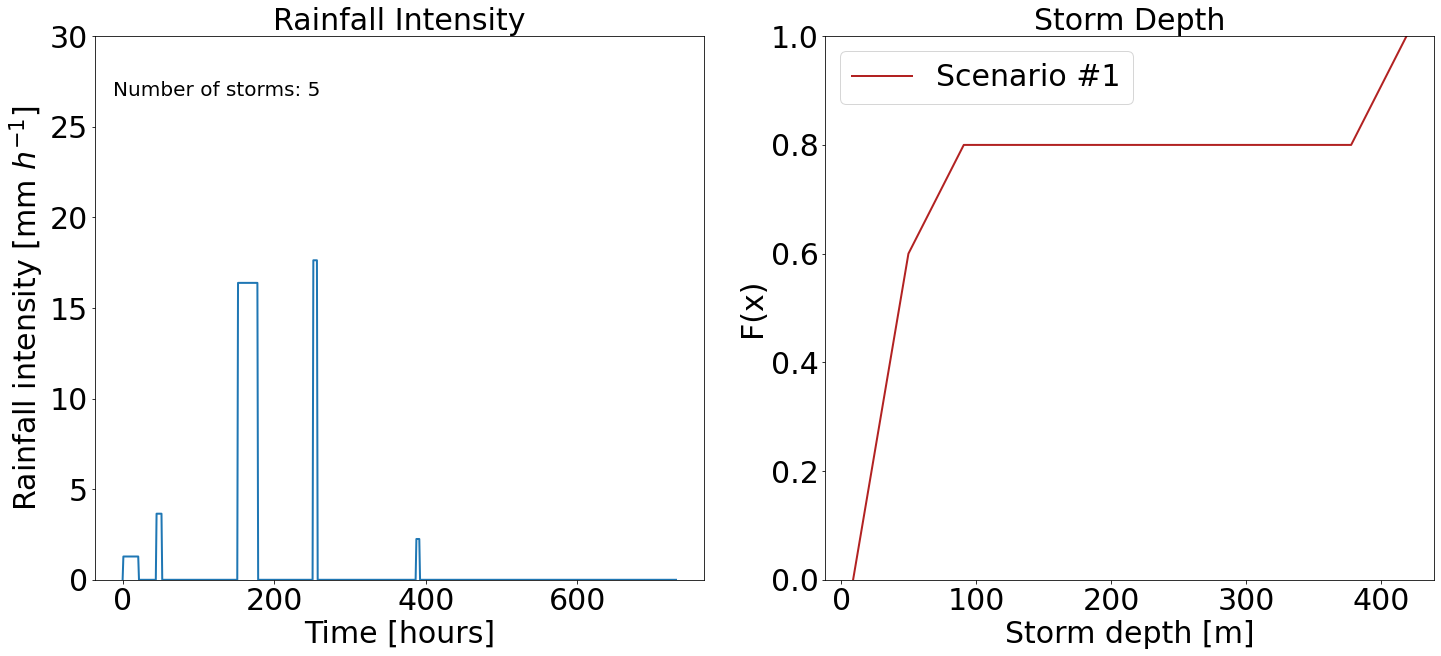

In [9]:
## Plotting rainstorms -  Scenario #1  
fig, ax = plt.subplots(1,2, figsize = (24,10))
number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,0])))
ax[0].plot(times_vector[:,0]/60,rains_vector[:,0],linewidth=2)   
ax[0].set_xlabel('Time [hours]',fontsize=30)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)
ax[0].set_ylim([0,30])
ax[0].set_title('Rainfall Intensity',fontsize=30)
ax[0].text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes,fontsize=20)

ax[0].tick_params(axis = 'x', labelsize = 30)
ax[0].tick_params(axis = 'y', labelsize = 30)


## Plotting rainstorm depth CDF-plot
hist, bin_edges = np.histogram(depths_vector[:,0][~np.isnan(depths_vector[:,0])]) # This part was giving an error?, normed=True)
b = [0]
b.extend(np.cumsum(hist)/np.sum(hist))
ax[1].plot(bin_edges,b,label=('Scenario #'+str(1)),linewidth=2,color='firebrick')
ax[1].set_xlabel('Storm depth [m]',fontsize=30)
ax[1].set_ylabel('F(x)',fontsize=30)
ax[1].set_ylim([0,1.])
ax[1].set_title('Storm Depth',fontsize=30)
ax[1].legend(fontsize=30)
ax[1].tick_params(axis = 'x', labelsize = 30)
ax[1].tick_params(axis = 'y', labelsize = 30)


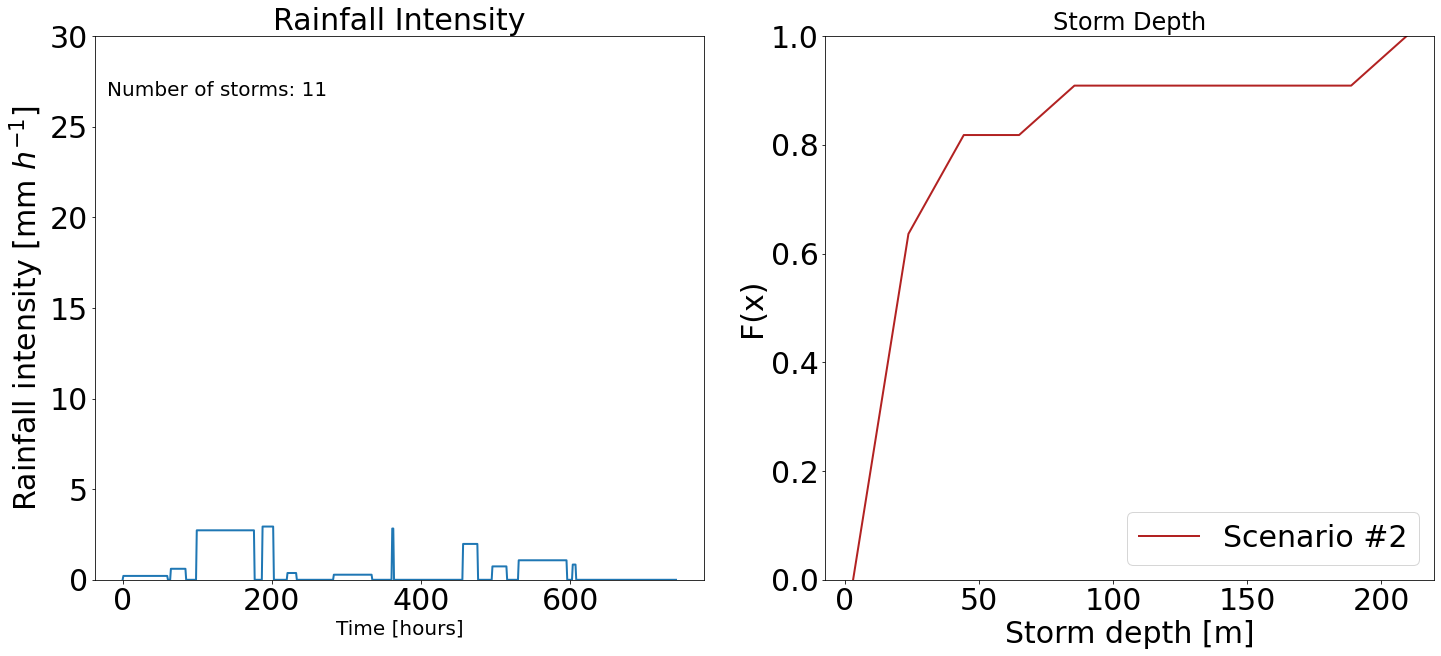

In [10]:

## Plotting rainstorms  - Scenario #2
fig, ax = plt.subplots(1,2, figsize = (24,10))
number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,1])))
ax[0].plot(times_vector[:,1]/60,rains_vector[:,1],linewidth=2)   
ax[0].set_xlabel('Time [hours]',fontsize=20)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)
ax[0].set_ylim([0,30])
ax[0].set_title('Rainfall Intensity',fontsize=30)
ax[0].text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes,fontsize=20)

ax[0].tick_params(axis = 'x', labelsize = 30)
ax[0].tick_params(axis = 'y', labelsize = 30)

## Plotting rainstorm depth CDF-plot
hist, bin_edges = np.histogram(depths_vector[:,1][~np.isnan(depths_vector[:,1])]) # This part was giving an error?, normed=True)
b = [0]
b.extend(np.cumsum(hist)/np.sum(hist))
ax[1].plot(bin_edges,b,label=('Scenario #'+str(2)),linewidth=2,color='firebrick')
ax[1].set_xlabel('Storm depth [m]',fontsize=30)
ax[1].set_ylabel('F(x)',fontsize=30)
ax[1].set_ylim([0,1.])
ax[1].set_title('Storm Depth',fontsize=24)
ax[1].legend(fontsize=30)

ax[1].tick_params(axis = 'x', labelsize = 30)
ax[1].tick_params(axis = 'y', labelsize = 30)


### Plot both rainfall series on top of one another to compare

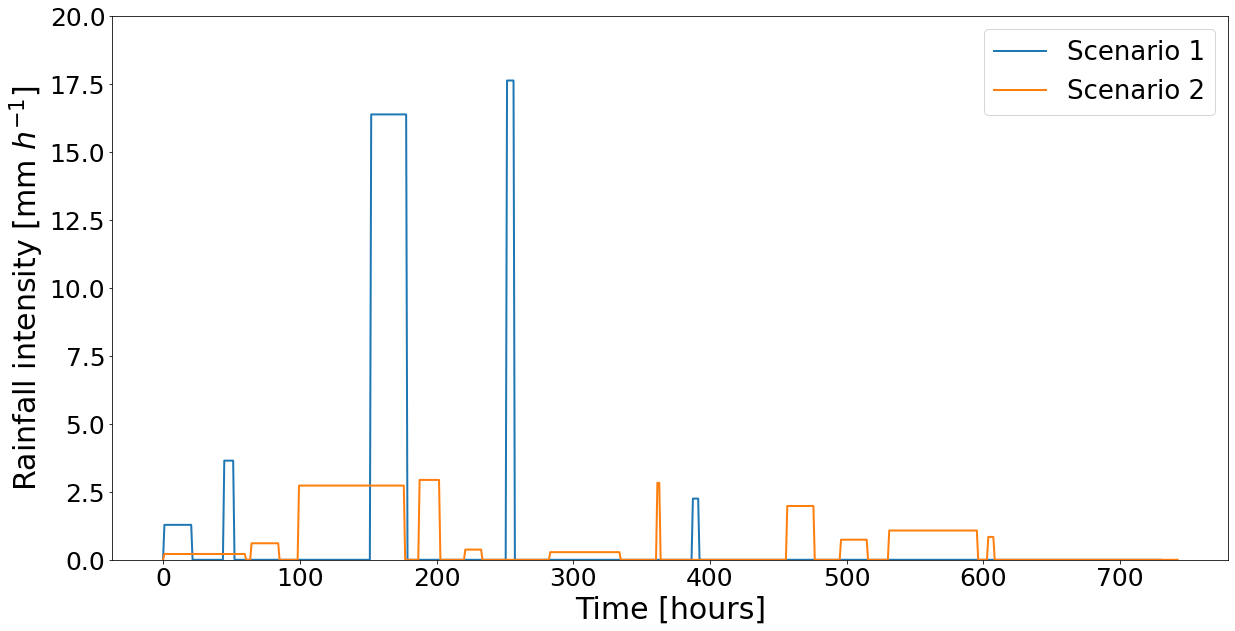

In [11]:
plt.figure(figsize=(20,10))
plt.plot(times_vector[:,0]/60,rains_vector[:,0],linewidth=2, label = "Scenario 1")   
plt.plot(times_vector[:,1]/60,rains_vector[:,1],linewidth=2,label = "Scenario 2")   

plt.xlabel('Time [hours]',fontsize=30)
plt.ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)
plt.ylim([0,20])
plt.xticks(fontsize= 25)
plt.yticks(fontsize= 25)
plt.legend(fontsize=26)

## Optional 3rd Scenario
If you add a third scenario in the csv, comment out the code below to see the intensity and storm depth for that scenario.

In [ ]:
# ## Plotting rainstorms  - Scenario #3
# fig, ax = plt.subplots(1,2, figsize = (24,10))
# number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,2])))
# ax[0].plot(times_vector[:,2]/60,rains_vector[:,2,linewidth=2)   
# ax[0].set_xlabel('Time [hours]',fontsize=20)
# ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=18)
# ax[0].set_ylim([0,30])
# ax[0].set_title('Rainfall Intensity',fontsize=24)
# ax[0].text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes,fontsize=20)

# ## Plotting rainstorm depth CDF-plot
# hist, bin_edges = np.histogram(depths_vector[:,2][~np.isnan(depths_vector[:,2])]) # This part was giving an error?, normed=True)
# b = [0]
# b.extend(np.cumsum(hist)/np.sum(hist))
# ax[1].plot(bin_edges,b,label=('Scenario #'+str(2)),linewidth=2,color='firebrick')
# ax[1].set_xlabel('Storm depth [m]',fontsize=18)
# ax[1].set_ylabel('F(x)',fontsize=18)
# ax[1].set_ylim([0,1.])
# ax[1].set_title('Storm Depth',fontsize=24)
# ax[1].legend(fontsize=20)

# Runoff and infiltration

In the model, at each time step and for each cell, the rain accumulates the water column above ground each cell. Some of the water infiltrates with the `SoilInfiltrationGreenAmpt` and the remainder is moved through the basin drainage with the `OverlandFlow component` 

### Overlandlandflow component
<img align="right" src="https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/TypicalValues.PNG?raw=true" alt="drawing" width="400"/>

The elevation grid controls the overland flow component. Slope and basin drainage size can have a strong impact on the stream hydrograph.

<small>For more on the `OverlandFlow` component, click here: <a href="https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html">https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html</a></small>


### Soil Infiltration component

The infiltration of water in the soil can be described by $q$, which is the velocity at which the water is moving through the soil. $q$ is usually in $m/s$ and is controlled by the hydraulic conductivity $K$ and by the hydraulic gradient $\Psi$.

$q = K\Psi$

<small>For more on the `SoilInfiltrationGreenAmpt` component, click here: <a href="https://landlab.readthedocs.io/en/master/reference/components/greenampt.html">https://landlab.readthedocs.io/en/master/reference/components/greenampt.html</a></small>

#### Hydraulic conductivity $K$ ($m/s$)

The hydraulic conductivity caracterize the ability of water to move through a medium (ex: soil or rock) and is controlled by the porosity of the material $\kappa$ and the viscosity of the fluid $\mu$. It can be described with by $K=\kappa \frac{\rho g}{\mu}$, where $\rho$ is the density of water and $g$ the gravity.

Example of hydraulic conductivity for different type of material (in m/s) shown here (*Domenico and Schwartz 1990*). 

#### Hydraulic gradient $\Psi$ (–)

The hydraulic gradient controls the force applied on the water column, which will force the water through the soil. The larger the water column, the water the water will move through the soil at the bottom of the water column. The hydraulic gradient is described with $\Psi = \frac{H}{d}$, where $H$ is the entire water column and $d$ is the soil saturated column.

<img align="center" src="https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/Soil_infiltration_illustration.png?raw=true" alt="drawing" width="1000"/>

## Define Parameters for the infiltration:
Below you will set the hydraulic conductivity parameter, K. Remember, this value describes/controls how fast the water can move through the soil and the units are in meters per second (m/s). A larger K (ex: 1e-4) means that water will move faster and a smaller K (ex: 1e-5) means that the water will infiltrate slower. 

*K_vec* holds the hydraulic conductivity values for [scenario 1, scenario 2]. For now, have these be the same value. Since the rainfall parameters are different you want to hold these constant to see the effect of rainfall intensity while controlling for other variables. 

In [12]:
#Prepare parameters and vectors for infiltration and runoff simulations

## Basin Hydraulic conductivity
K_vec = [2.0E-5,2.0E-5]

## Create vectors for saving outlet data
outlet_times_vector =np.empty((5000,2,))
outlet_times_vector[:]=np.nan
outlet_depth_vector = np.empty((5000,2,))
outlet_depth_vector[:] = np.nan
mean_SI_vector = np.empty((5000,2,))
mean_SI_vector[:]=np.nan


In [13]:
## Mainloop - rainfall-runoff simulation
for rs in StormsDF.index: #Iterating over the scenarios
    print('---------------------------------------')
    # Get the storm data
    interstorm_dts = interstorms_dts_vector[:,rs][~np.isnan(interstorms_dts_vector[:,rs])]
    storm_dts = storms_dts_vector[:,rs][~np.isnan(storms_dts_vector[:,rs])]
    intensities = intensities_vector[:,rs][~np.isnan(intensities_vector[:,rs])]
    time_vec=times_vector[:,rs][~np.isnan(times_vector[:,rs])]
    rain_vec=rains_vector[:,rs][~np.isnan(rains_vector[:,rs])]


    #Define hydraulic conductivity parameters for the two different simulation the infiltration component
    K =  K_vec[rs]  
    hydraulic_conductivity = mg.ones('node')*K
    
    # Set initial values for h and d for both cases (VERIFY THAT THIS IS TRUE???)
    
    ## initial soil infilatration depth in the soil -- case 1
    d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
    d = mg.at_node['soil_water_infiltration__depth']
    d *= 0.15
    print('initial soil water infiltration depth: ', d) 
    
    
    ## Surface water case 1
    mg.add_zeros('surface_water__depth',at='node')  # a veneer of water  the model
    h = mg.at_node['surface_water__depth']
    h += 0.0001
    print('initial surface water depth: ', h)
    
    ## Initialize model
    SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity)
    of = OverlandFlow(mg, steep_slopes=True)
    
    
    
    ## Change storm times to minutes
    interstorm_dts_min = np.asanyarray(interstorm_dts)*60 ## in minutes
    storm_dts_min = np.asanyarray(storm_dts)*60 ## in minutes
    global_time = np.sum(interstorm_dts_min) + np.sum(storm_dts_min)
    
    
    
    ## Arrays for saving inputs and counters -- case 1
    SI_mean_vec = []
    outlet_depth = []
    outlet_times = []
    elapsed_time = 0
    node_of_max_q = 2126
    
    
    
    ## Better color map for plotting overlandflow
    colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
    cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)
    
    
    peak_discharge = 0
    peak_waterlevel = 0
    ## Main loop
    for i in  range(0,len(storm_dts_min)):
        storm_t = storm_dts_min[i]
        interstorm_t = interstorm_dts_min[i]
        total_time_step = storm_t + interstorm_t
        storm_time = 0 
        print(str(np.round((elapsed_time/global_time)*100))+ '% from total run time of scenario #' +str(rs+1))
        while storm_time < total_time_step:
            if storm_time < (total_time_step - interstorm_t):
                dt_overland = 10
                mg.at_node['surface_water__depth'] += (intensities[i]/(60))*0.001*dt_overland ## meter in ovrelandflow dt
                SI.run_one_step(dt=dt_overland)
                SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
                of.run_one_step(dt=dt_overland)
                elapsed_time += dt_overland
                outlet_times.append(elapsed_time) 
                outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
                storm_time += dt_overland
            else:
                SI.run_one_step(dt=dt_overland)
                of.run_one_step(dt=dt_overland)
                SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
                # Increased elapsed time
                elapsed_time += dt_overland
                outlet_times.append(elapsed_time) 
                outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
                storm_time += dt_overland 
            #if elapsed_time % 1000 == 0:    ## UNCOMMENT THIS SECTION IF YOU WANT TO PLOT RUNOFF ON BASIN
                #fig = plt.figure(1)
                #imshow_grid(mg,'topographic__elevation',colorbar_label='Elevation (m)')
                #imshow_grid(mg,'surface_water__depth',limits=(0,0.6),cmap=cmap,colorbar_label='Water depth (m)')
                #plt.title(f'Time = {round(elapsed_time,1)} s')
                #plt.show()
            if mg.at_link['surface_water__discharge'][node_of_max_q] > peak_discharge:
                peak_discharge = mg.at_link['surface_water__discharge'][node_of_max_q]
            if np.max(outlet_depth) > peak_waterlevel:
                peak_waterlevel = np.max(outlet_depth)
          
    StormsDF.loc[rs,'PeakWaterLevel'] = peak_waterlevel
    mg.delete_field('node','surface_water__depth') # Clear field for the next run
    mg.delete_field('node','soil_water_infiltration__depth') # Clear field for the next run
    
    outlet_times_vector[0:len(outlet_times),rs]=outlet_times
    outlet_depth_vector[0:len(outlet_depth),rs]=outlet_depth
    mean_SI_vector[0:len(SI_mean_vec),rs] = SI_mean_vec
                
            

0.0% from total run time of scenario #1
6.0% from total run time of scenario #1
20.0% from total run time of scenario #1
34.0% from total run time of scenario #1
53.0% from total run time of scenario #1
0.0% from total run time of scenario #2
9.0% from total run time of scenario #2
13.0% from total run time of scenario #2
25.0% from total run time of scenario #2
30.0% from total run time of scenario #2
38.0% from total run time of scenario #2
48.0% from total run time of scenario #2
61.0% from total run time of scenario #2
67.0% from total run time of scenario #2
71.0% from total run time of scenario #2
81.0% from total run time of scenario #2


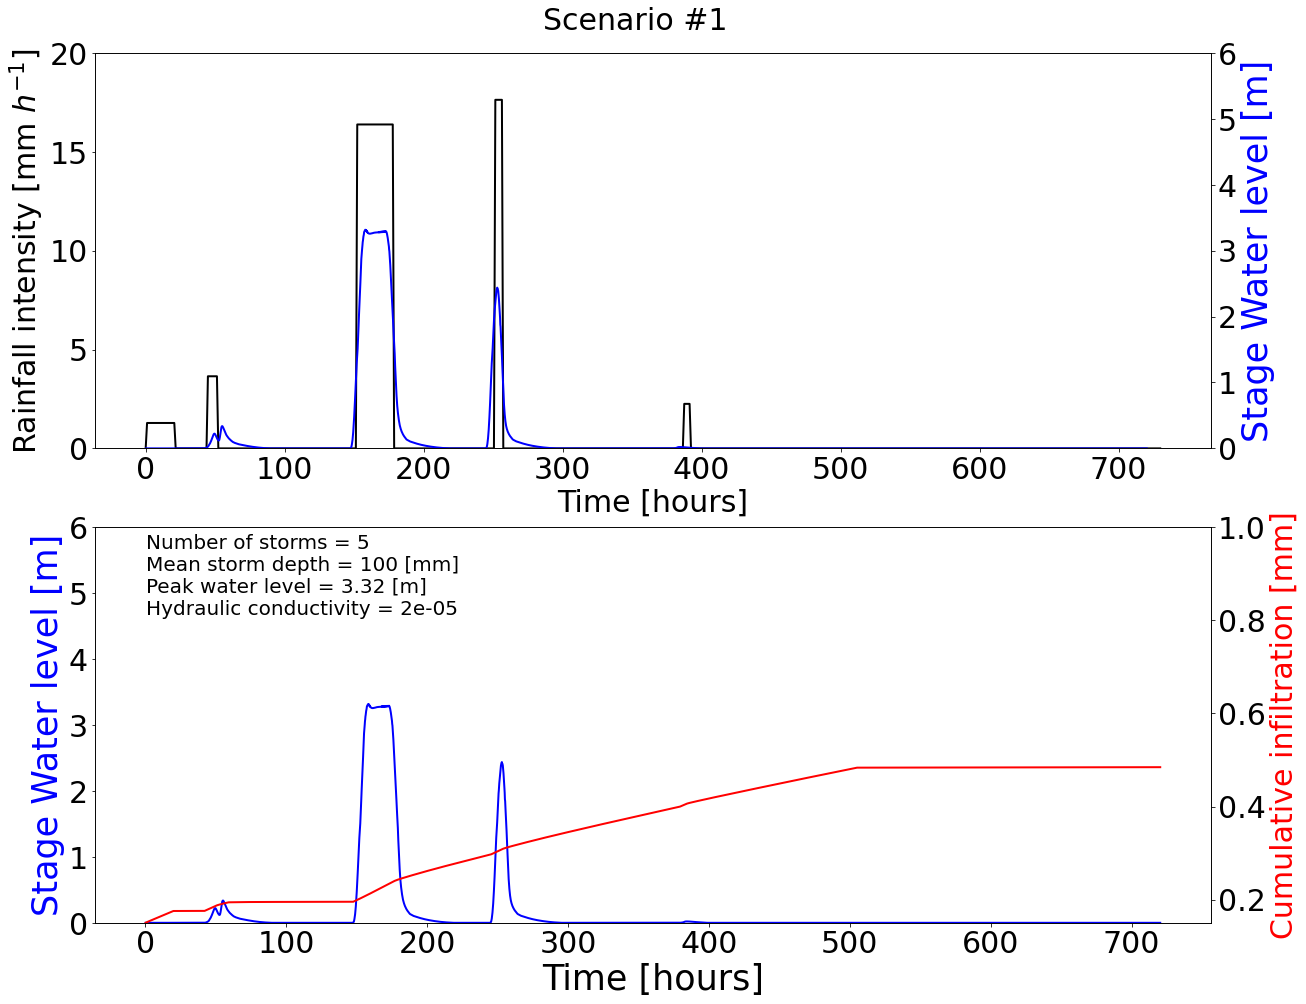

In [14]:
## Plotting results for Scenario #1
fig, ax = plt.subplots(2,1, figsize = (20,16))
plt.suptitle(('Scenario #'+str(1)),fontsize=30,y=0.92)
number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,0])))
ax[0].plot(times_vector[:,0]/60,rains_vector[:,0],linewidth=2, color = 'black')   
ax[0].set_xlabel('Time [hours]',color = 'black',fontsize=30)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)

ax[0].tick_params(axis = 'x', labelsize = 30)
ax[0].tick_params(axis = 'y', labelsize = 30)

#If you rerun new scenarios you may need to change the ylim to show the full peak!
ax[0].set_ylim([0,20])
ax2 = ax[0].twinx()

ax2.plot((outlet_times_vector[:,0]/60),outlet_depth_vector[:,0],color='blue',linewidth=2)
ax2.set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
ax2.set_xlabel('Time [hours]',fontsize=25)
ax2.set_ylim([0, 6])

ax2.tick_params(axis = 'y', labelsize = 30)

peak_out = str(np.round(StormsDF.iloc[0]['PeakWaterLevel'],2))
ax[1].plot((outlet_times_vector[:,0]/60),outlet_depth_vector[:,0],color='blue',linewidth=2)
ax[1].set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
ax[1].set_xlabel('Time [hours]',fontsize=35)
ax[1].set_ylim([0, 6])

ax[1].tick_params(axis = 'x', labelsize = 30)
ax[1].tick_params(axis = 'y', labelsize = 30)

ax3=ax[1].twinx()
ax3.plot(outlet_times_vector[:,0]/60,mean_SI_vector[:,0],color="red",linewidth=2)
ax3.set_ylabel("Cumulative infiltration [mm]",color="red",fontsize=30)
ax3.set_ylim([0.15, 1])
ax[1].annotate('Number of storms = ' + number_of_storms+'\nMean storm depth = '+ str(StormsDF.loc[0]['StormDepth'])+ ' [mm]'
               '\nPeak water level = '+ peak_out + ' [m]' +
               '\nHydraulic conductivity = ' +str(K_vec[0]), xy=(0.5, 0.78),
               xycoords=("data", "axes fraction"),fontsize=20)
ax3.tick_params(axis = 'y', labelsize = 30)

plt.show()

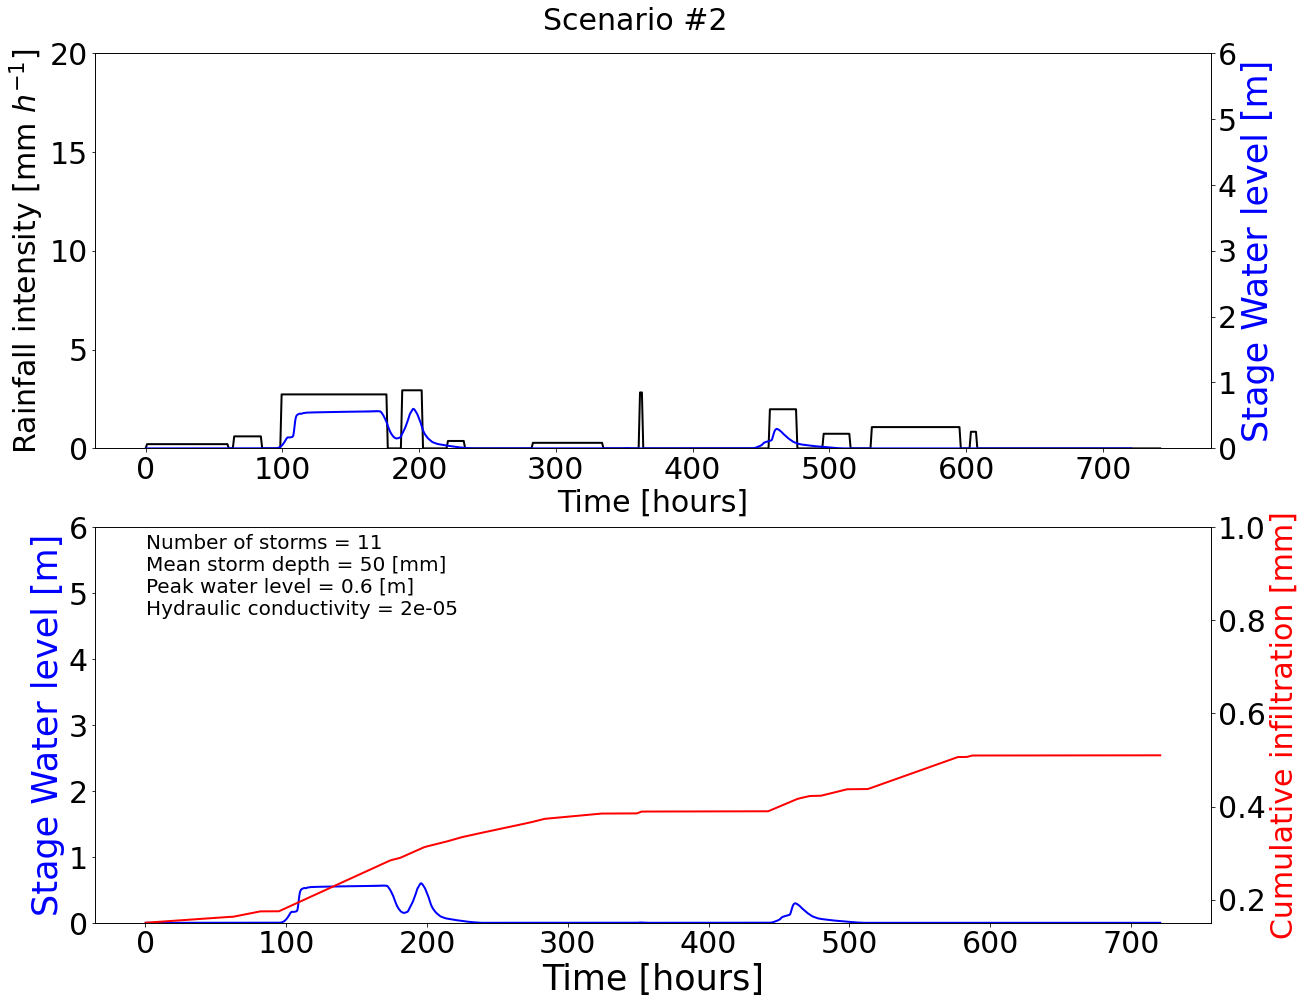

In [15]:
## Plotting results for Scenario #2
fig, ax = plt.subplots(2,1, figsize = (20,16))
plt.suptitle(('Scenario #'+str(2)),fontsize=30,y=0.92)
number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,1])))
ax[0].plot(times_vector[:,1]/60,rains_vector[:,1],linewidth=2, color = 'black')   
ax[0].set_xlabel('Time [hours]', color = 'black',fontsize=30)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)
ax[0].tick_params(axis = 'x', labelsize = 30)
ax[0].tick_params(axis = 'y', labelsize = 30)

#If you rerun new scenarios you may need to change the ylim to show the full peak!
ax[0].set_ylim([0,20])


ax2 = ax[0].twinx()

ax2.plot((outlet_times_vector[:,1]/60),outlet_depth_vector[:,1],color='blue',linewidth=2)
ax2.set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
ax2.set_xlabel('Time [hours]',fontsize=25)
ax2.set_ylim([0, 6])

ax2.tick_params(axis = 'y', labelsize = 30)

peak_out = str(np.round(StormsDF.iloc[1]['PeakWaterLevel'],2))
ax[1].plot(outlet_times_vector[:,1]/60,outlet_depth_vector[:,1],color='blue',linewidth=2)
ax[1].set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
ax[1].set_xlabel('Time [hours]',fontsize=35)
ax[1].set_ylim([0, 6])

ax[1].tick_params(axis = 'x', labelsize = 30)
ax[1].tick_params(axis = 'y', labelsize = 30)

ax3=ax[1].twinx()
ax3.plot(outlet_times_vector[:,1]/60,mean_SI_vector[:,1],color="red",linewidth=2)
ax3.set_ylabel("Cumulative infiltration [mm]",color="red",fontsize=30)
ax3.set_ylim([0.15, 1])
ax[1].annotate('Number of storms = ' + number_of_storms+'\nMean storm depth = '+ str(StormsDF.loc[1]['StormDepth'])+ ' [mm]'
               '\nPeak water level = '+ peak_out + ' [m]' +
               '\nHydraulic conductivity = ' +str(K_vec[1]), xy=(0.5, 0.78),
               xycoords=("data", "axes fraction"),fontsize=20)
ax3.tick_params(axis = 'y', labelsize = 30)


plt.show()


## Uncomment the following text box to plot scenario 3

In [16]:
# ## Plotting results for Scenario #3
# fig, ax = plt.subplots(2,1, figsize = (20,16))
# plt.suptitle(('Scenario #'+str(2)),fontsize=30,y=0.92)
# number_of_storms = str(np.count_nonzero(~np.isnan(intensities_vector[:,1])))
# ax[0].plot(times_vector[:,1]/60,rains_vector[:,1],linewidth=2, color = 'black')   
# ax[0].set_xlabel('Time [hours]', color = 'black',fontsize=30)
# ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=30)
# ax[0].tick_params(axis = 'x', labelsize = 30)
# ax[0].tick_params(axis = 'y', labelsize = 30)

# #If you rerun new scenarios you may need to change the ylim to show the full peak!
# ax[0].set_ylim([0,20])


# ax2 = ax[0].twinx()

# ax2.plot((outlet_times_vector[:,1]/60),outlet_depth_vector[:,1],color='blue',linewidth=2)
# ax2.set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
# ax2.set_xlabel('Time [hours]',fontsize=25)
# ax2.set_ylim([0, 6])

# ax2.tick_params(axis = 'y', labelsize = 30)

# peak_out = str(np.round(StormsDF.iloc[1]['PeakWaterLevel'],2))
# ax[1].plot(outlet_times_vector[:,2]/60,outlet_depth_vector[:,2],color='blue',linewidth=2)
# ax[1].set_ylabel('Stage Water level [m]',color='blue',fontsize=35)
# ax[1].set_xlabel('Time [hours]',fontsize=35)
# ax[1].set_ylim([0, 6])

# ax[1].tick_params(axis = 'x', labelsize = 30)
# ax[1].tick_params(axis = 'y', labelsize = 30)

# ax3=ax[1].twinx()
# ax3.plot(outlet_times_vector[:,2]/60,mean_SI_vector[:,2],color="red",linewidth=2)
# ax3.set_ylabel("Cumulative infiltration [mm]",color="red",fontsize=30)
# ax3.set_ylim([0.15, 1])
# ax[1].annotate('Number of storms = ' + number_of_storms+'\nMean storm depth = '+ str(StormsDF.loc[1]['StormDepth'])+ ' [mm]'
#                '\nPeak water level = '+ peak_out + ' [m]' +
#                '\nHydraulic conductivity = ' +str(K_vec[1]), xy=(0.5, 0.78),
#                xycoords=("data", "axes fraction"),fontsize=20)
# ax3.tick_params(axis = 'y', labelsize = 30)


# plt.show()


# Assignment Questions

### Question 1

Compare the final rainfall intensity, hydrograph, and total soil infiltration plots for scenario 1 and 2.
    
    a. What happens in the hydrograph when there are storm events (peaks in rainfall intensity)? How does the stage water level compare when there is a high vs low intensity rainfall storm?

    b. How does the cumulative infiltration [mm] value at the end of the time series compare for each scenario? Why might this be? 

### Question 2

Edit storm_params.csv so that scenario 1 has more storm events and even higher intensity! Hint- how you might change storm depth and storm time and storm intertime to accomplish this?
    
    a. What did this do to the appearance of the hydrograph?
    
    b. What did this do to the cumulative infiltration [mm] values?   

### Question 3

Change storm_params.csv so that each scenario has the same parameters (provide parameters or describe the type of scenario they should aim for?). Now, change the K_vec variable in the “#Prepare parameters and vectors for run off simulations” section to two contrasting hydraulic conductivity (K) values. Remember K controls how fast the water can move through the soil. A larger K(ex 1e-3) means that water will move faster while a smaller K (ex 1e-6) means the water will take longer to infiltrate.

Compare the two scenarios and answer the following questions
   
   a. How do the hydrographs compare? Is one more "flashy" than the other? What about the maximum rain intensity values?
   
   b. What about the total soil infiltration? Does the rate at which the cummulative infilitration increase differ between the two (qualitative answer is sufficient)? What about the final depth at the end of the scenarios?